In [13]:
import numpy as np
import scanpy as sc
import anndata
import scvi
from scib_metrics.benchmark import Benchmarker
import torch
import scib_metrics
from lightning.pytorch.callbacks import ModelCheckpoint
import copy
%matplotlib inline
import sys
sys.path.append('..')
from functions import *
from SCVIModelCheckpoint import SCVIModelCheckpoint 

In [2]:
adata = anndata.read_h5ad(filename="../data/adataLung4.h5ad")
scvi.model.SCVI.setup_anndata(adata, layer="counts")

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [3]:
adata

AnnData object with n_obs × n_vars = 32472 × 4000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'Scanorama', 'Unintegrated', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
def hyperTraining(adata, prior, hyperpar, ks, n_epochs_kl_warmup, max_epochs, beta = 5, early_stopping=False):
    adatac = adata.copy()
    keys = []
    for k in ks:
        vae = scvi.model.SCVI(adata, prior_distribution=prior, prior_kwargs={hyperpar:k})
        vae.train(plan_kwargs={"max_kl_weight":beta,"n_epochs_kl_warmup":n_epochs_kl_warmup},max_epochs=max_epochs,early_stopping=early_stopping)
        keys.append(f"scVI_k={k}")
        adatac.obsm[f"scVI_k={k}"] = vae.get_latent_representation()
    return adatac, keys

In [5]:
def plotMetricsHyper(bm, keys, ks):
    benchmark_results = bm.get_results(min_max_scale=False)
    metrics = benchmark_results.keys()
    metrics_results = []
    for i in range(len(metrics)):
        metrics_results.append([])
        for j in range(ks):
            metrics_results[i].append(benchmark_results[metrics[i]][keys[i]])
        plt.plot(ks,metrics_results[i])
        plt.title(metrics[i])
        plt.xlabel("k")
        plt.show()

In [17]:
ks = [1, 10, 50, 100, 500]
ks2 = [2, 10, 50, 100, 500]
nls = [1, 4, 8, 16, 32]

In [7]:
adataMG, keysMG = hyperTraining(adata, "mixofgaus", "k", ks, 200, 300)
bmMG = runBenchmark(adataMG, keysMG, nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans = True, silhouette_label=True, silhouette_batch = True, kbet_per_label=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [10:00<00:00,  1.96s/it, v_num=1, train_loss_step=901, train_loss_epoch=928]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [10:00<00:00,  2.00s/it, v_num=1, train_loss_step=901, train_loss_epoch=928]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [11:18<00:00,  2.21s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=922]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [11:18<00:00,  2.26s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=922]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [10:03<00:00,  1.71s/it, v_num=1, train_loss_step=974, train_loss_epoch=918]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [10:03<00:00,  2.01s/it, v_num=1, train_loss_step=974, train_loss_epoch=918]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [08:57<00:00,  1.77s/it, v_num=1, train_loss_step=898, train_loss_epoch=919]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [08:57<00:00,  1.79s/it, v_num=1, train_loss_step=898, train_loss_epoch=919]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [10:27<00:00,  1.83s/it, v_num=1, train_loss_step=873, train_loss_epoch=917]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [10:27<00:00,  2.09s/it, v_num=1, train_loss_step=873, train_loss_epoch=917]


Embeddings: 100%|██████████| 5/5 [02:09<00:00, 25.92s/it]


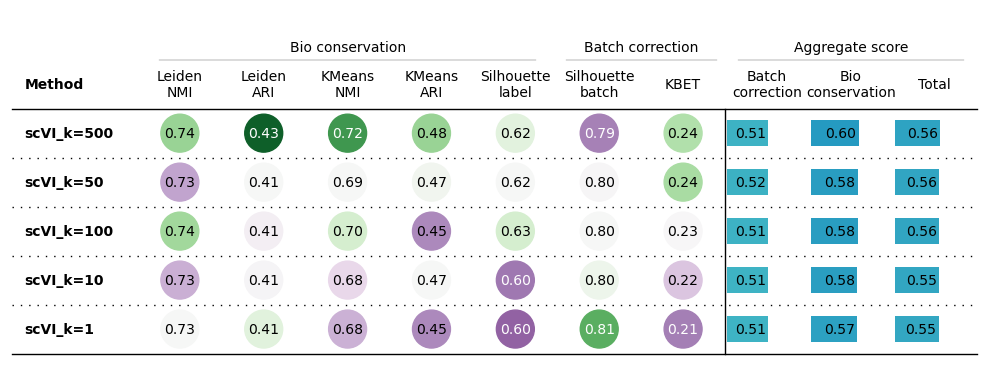

In [15]:
bmMG.plot_results_table(min_max_scale=False)

In [18]:
adataVP, keysVP = hyperTraining(adata, "vamp", "n_components", ks2, 200, 300)
bmVP = runBenchmark(adataVP, keysVP, nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans=True, silhouette_label=True, silhouette_batch=True, kbet_per_label=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [09:50<00:00,  1.97s/it, v_num=1, train_loss_step=962, train_loss_epoch=930]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [09:50<00:00,  1.97s/it, v_num=1, train_loss_step=962, train_loss_epoch=930]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [09:25<00:00,  1.89s/it, v_num=1, train_loss_step=930, train_loss_epoch=925]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [09:25<00:00,  1.88s/it, v_num=1, train_loss_step=930, train_loss_epoch=925]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [09:20<00:00,  1.89s/it, v_num=1, train_loss_step=883, train_loss_epoch=920]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [09:20<00:00,  1.87s/it, v_num=1, train_loss_step=883, train_loss_epoch=920]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [09:31<00:00,  1.86s/it, v_num=1, train_loss_step=881, train_loss_epoch=919]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [09:31<00:00,  1.90s/it, v_num=1, train_loss_step=881, train_loss_epoch=919]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [09:21<00:00,  1.87s/it, v_num=1, train_loss_step=935, train_loss_epoch=918]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [09:21<00:00,  1.87s/it, v_num=1, train_loss_step=935, train_loss_epoch=918]


Embeddings: 100%|██████████| 5/5 [01:51<00:00, 22.36s/it]


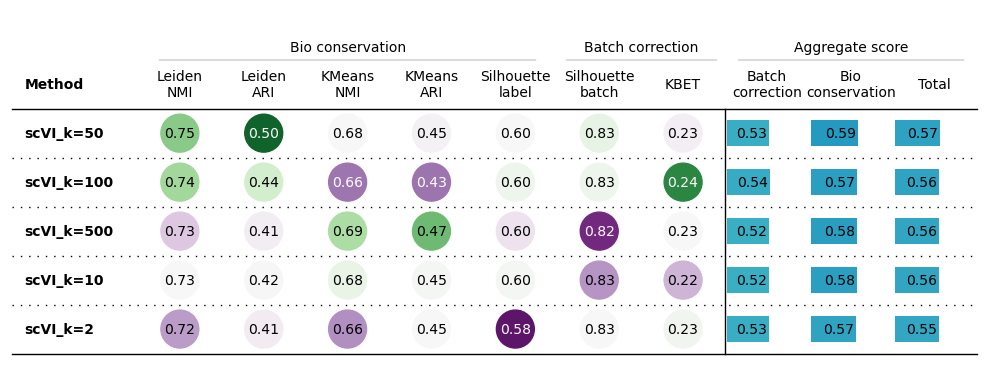

In [19]:
bmVP.plot_results_table(min_max_scale=False)

In [20]:
adataNF, keysNF = hyperTraining(adata, "normalflow", "num_layers", nls, 200, 300)
bmNF = runBenchmark(adataNF, keysNF, nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans=True, silhouette_label=True, silhouette_batch=True, kbet_per_label=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [08:21<00:00,  1.66s/it, v_num=1, train_loss_step=959, train_loss_epoch=923]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [08:21<00:00,  1.67s/it, v_num=1, train_loss_step=959, train_loss_epoch=923]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [11:04<00:00,  2.22s/it, v_num=1, train_loss_step=878, train_loss_epoch=921]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [11:04<00:00,  2.21s/it, v_num=1, train_loss_step=878, train_loss_epoch=921]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [14:42<00:00,  2.95s/it, v_num=1, train_loss_step=955, train_loss_epoch=921]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [14:42<00:00,  2.94s/it, v_num=1, train_loss_step=955, train_loss_epoch=921]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [22:12<00:00,  4.45s/it, v_num=1, train_loss_step=918, train_loss_epoch=921]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [22:12<00:00,  4.44s/it, v_num=1, train_loss_step=918, train_loss_epoch=921]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [36:27<00:00,  7.24s/it, v_num=1, train_loss_step=927, train_loss_epoch=921]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [36:27<00:00,  7.29s/it, v_num=1, train_loss_step=927, train_loss_epoch=921]


Embeddings: 100%|██████████| 5/5 [01:47<00:00, 21.49s/it]


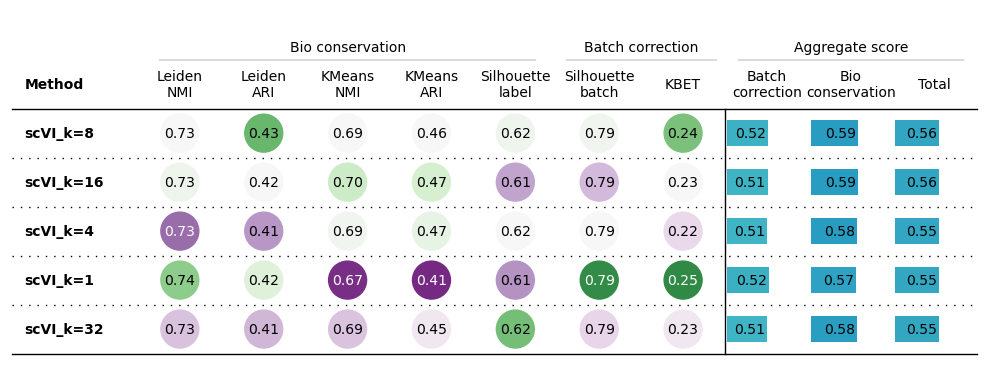

In [21]:
bmNF.plot_results_table(min_max_scale=False)